About Dataset


IMDB dataset having 50K movie reviews for natural language processing or Text analytics. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training and 25,000 for testing. So, predict the number of positive and negative reviews using either classification or deep learning algorithms.

In [1]:
# Import all required libraries
import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.util import ngrams
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style()

import os

In [2]:
# Loading and reading the dataset
df = pd.read_csv('/content/drive/MyDrive/NLP: IMDB Dataset/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
print('Shape  = ',df.shape) # print shape of dataset
print(df['sentiment'].value_counts()) # total count of different values in df.sentiments

Shape  =  (50000, 2)
positive    25000
negative    25000
Name: sentiment, dtype: int64


<Axes: xlabel='sentiment', ylabel='count'>

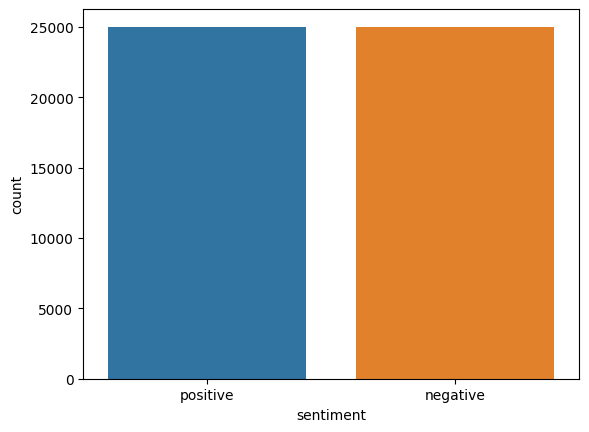

In [4]:
sns.countplot(x = df['sentiment'])

Abover countplot shows values of sentiments in dataset where positive and negative data are having equal count.

In [5]:
# Take a look at review
df['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

As we can see, there are many

In [6]:
# take a look at sentiment of respective feedback

df['sentiment'][0]

'positive'

**Feature Engineering**



In [7]:
#Encoding the sentiment column so we can process it
df['sentiment'].replace({'positive' : 1 , 'negative' : 0} , inplace = True)

In [8]:
df.describe()

,sentiment
count,50000.000000
mean,0.500000
std,0.500005
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [9]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

We will remove '<br />' tags, create dummy values for our target, tokenize our sentences, remove the stopwords and convert abbreviations.

In [10]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [11]:
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word


def convert_abbrev_in_text(text):
  tokens = word_tokenize(text)
  tokens = [convert_abbrev(word) for word in tokens]
  text = ' '.join(tokens)
  return text

In [12]:
# remove html remains

df['review'] = df['review'].apply(lambda x:x.replace('<br />', ''))
df['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows wo

In [13]:
# <br />' HTML tags have been removed

In [14]:
# remove punctuations & tokenize
tokenizer = RegexpTokenizer(r'\w+')
df['tokens'] = df['review'].apply(tokenizer.tokenize)

In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
# remove stopwords and create a tokens column for our wordcloud
stopwords = stopwords.words('english')
df['tokens'] = df['tokens'].apply(lambda x: [w.lower() for w in x if w.lower() not in stopwords])

In [19]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [20]:
# convert abbreviations
df['review'] = df['review'].apply(lambda x: convert_abbrev_in_text(x))

**Exploratory Data Analysis**

Lets take a look at our reviews to get an idea what we are dealing with and how can we improve our technique to discriminate positive reviews and negative reviews.


Word Cloud

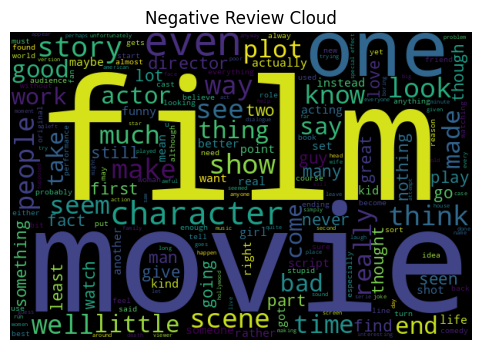

In [21]:
# WordCloud for negative reviews
rvw_tokens = ''
for tokens in df[df['sentiment'] == 0]['tokens']:
    rvw_tokens += " ".join(tokens)

wordcloud = WordCloud(width=600, height=400).generate(rvw_tokens)

plt.figure(figsize = (6, 4))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Negative Review Cloud')
plt.show()

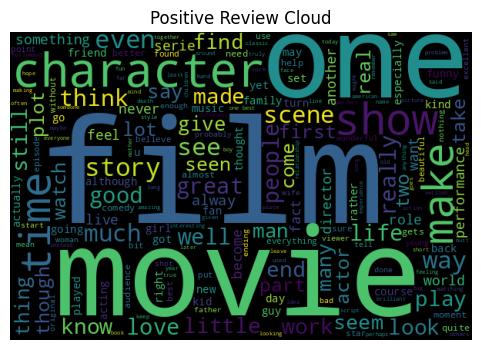

In [22]:
# WordCloud for Positive reviews
rvw_tokens = ''
for tokens in df[df['sentiment'] == 1]['tokens']:
    rvw_tokens += " ".join(tokens)

wordcloud = WordCloud(width=600, height=400).generate(rvw_tokens)

plt.figure(figsize = (6, 4))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Positive Review Cloud')
plt.show()

In [23]:
# N - Grams

def extract_ngrams(tokens, num):
    n_grams = ngrams(tokens, num)
    n_grams = [ ' '.join(grams) for grams in n_grams]
    return n_grams

def count_ngrams(df, num):
    gram_dict = {}
    for i in df:
        grams = extract_ngrams(i, num)
        for j in grams:
            if j in gram_dict:
                gram_dict[j] += 1
            else:
                gram_dict[j] = 1
    gram_dict = dict(sorted(gram_dict.items(), key=lambda item: item[1], reverse=True))
    return gram_dict

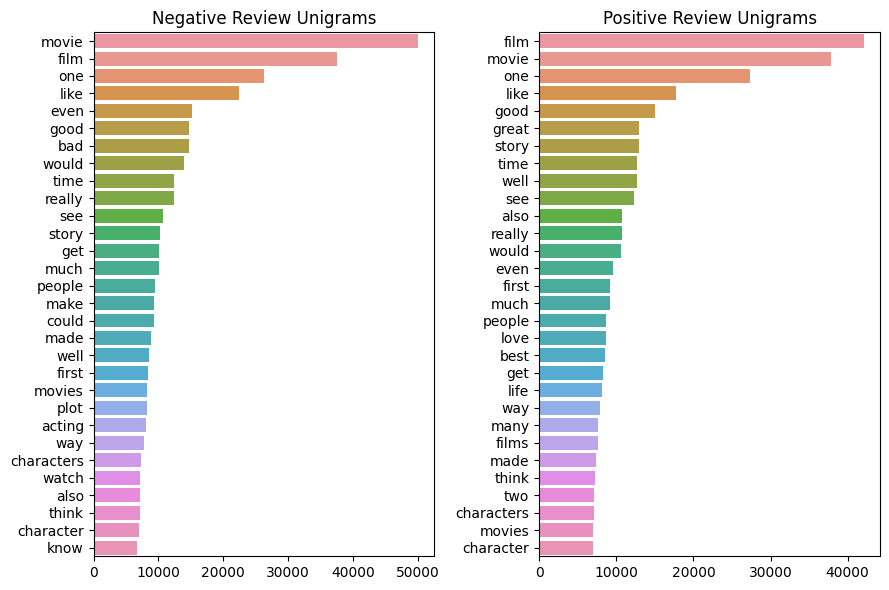

In [24]:
# Unigrams

unigrams_neg = count_ngrams(df[df['sentiment']==0]['tokens'], 1)
unigrams_pos = count_ngrams(df[df['sentiment']==1]['tokens'], 1)

fig, axes = plt.subplots(1, 2, figsize=(9,6))
num = 30
sns.barplot(x=list(unigrams_neg.values())[:num], y=list(unigrams_neg.keys())[:num], ax=axes[0])
sns.barplot(x=list(unigrams_pos.values())[:num], y=list(unigrams_pos.keys())[:num], ax=axes[1])

axes[0].set_title('Negative Review Unigrams')
axes[1].set_title('Positive Review Unigrams')

plt.tight_layout()
plt.show()

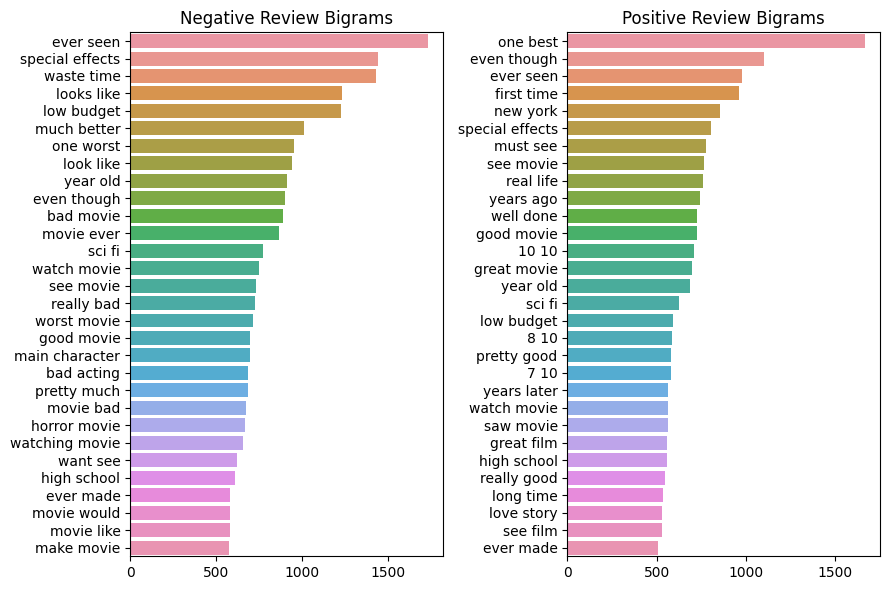

In [25]:
# Bigrams

bigrams_neg = count_ngrams(df[df['sentiment']==0]['tokens'], 2)
bigrams_pos = count_ngrams(df[df['sentiment']==1]['tokens'], 2)

fig, axes = plt.subplots(1, 2, figsize=(9,6))
num = 30
sns.barplot(x=list(bigrams_neg.values())[:num], y=list(bigrams_neg.keys())[:num], ax=axes[0])
sns.barplot(x=list(bigrams_pos.values())[:num], y=list(bigrams_pos.keys())[:num], ax=axes[1])

axes[0].set_title('Negative Review Bigrams')
axes[1].set_title('Positive Review Bigrams')

plt.tight_layout()
plt.show()

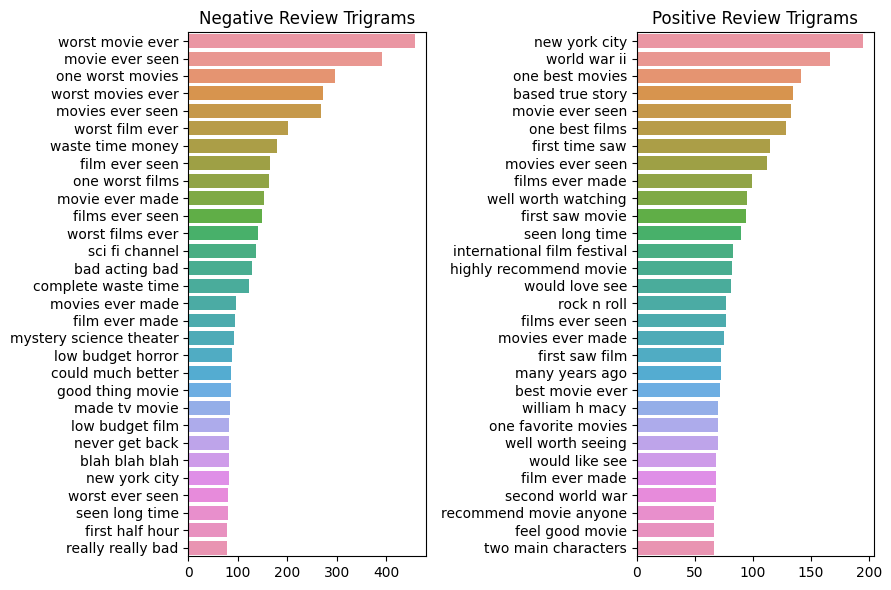

In [26]:
# Trigrams

trigrams_neg = count_ngrams(df[df['sentiment']==0]['tokens'], 3)
trigrams_pos = count_ngrams(df[df['sentiment']==1]['tokens'], 3)

fig, axes = plt.subplots(1, 2, figsize=(9,6))
num = 30
sns.barplot(x=list(trigrams_neg.values())[:num], y=list(trigrams_neg.keys())[:num], ax=axes[0])
sns.barplot(x=list(trigrams_pos.values())[:num], y=list(trigrams_pos.keys())[:num], ax=axes[1])

axes[0].set_title('Negative Review Trigrams')
axes[1].set_title('Positive Review Trigrams')

plt.tight_layout()
plt.show()

Train-Test Split with Stratified K-Fold

The difference between Stratified K-Fold and standard K-fold is that Stratified version balances the amount of classes in each K-Fold. As a result, in each K-Fold, there are same ratio of classes.

In [27]:
X = df['review']
y = df['sentiment']

kfold = StratifiedKFold(n_splits=10)
for i, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]


## **Classification of Reviews**
Since we need a numerical representation for our models, we will use TF-IDF to represent our texts. Then, we will train our models and decide which model we will improve on.

In [28]:
# Logistic Regression

%%time
# We will use only unigrams and bigrams since we don't want too much data
# We will also limit the frequency by setting df_min=0.0001, which will remove
# unneccessary rare words and lower the vocabulary length to 136752 from 2864394.
# This will allow our models to train faster and be more immune to overfit
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.0001)),
    ("classifier", LogisticRegression()),
])

pipeline_lr.fit(X_train, y_train)
print(f'train score: {pipeline_lr.score(X_train, y_train)}')
print(f'test score: {pipeline_lr.score(X_test, y_test)}')

train score: 0.9446888888888889
test score: 0.8984
CPU times: user 41.8 s, sys: 4.93 s, total: 46.8 s
Wall time: 43.5 s


In [29]:
y_pred = pipeline_lr.predict(X_test)
print('Classification Report:\n', classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
print('F1 Score: ', f1_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

    Negative       0.90      0.89      0.90      2500
    Positive       0.89      0.91      0.90      2500

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000

F1 Score:  0.8991663358475586


In [ ]:
# Support Vector Classifier

%%time
pipeline_svc = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.0001)),
    ("classifier", SVC()),
])

pipeline_svc.fit(X_train, y_train)
print(f'train score: {pipeline_svc.score(X_train, y_train)}')
print(f'test score: {pipeline_svc.score(X_test, y_test)}')

In [ ]:
y_pred = pipeline_svc.predict(X_test)
print('Classification Report:\n', classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
print('F1 Score: ', f1_score(y_test, y_pred))

In [ ]:
# Random Forest

%%time
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.0001)),
    ("classifier", RandomForestClassifier()),
])

pipeline_rf.fit(X_train, y_train)
print(f'train score: {pipeline_rf.score(X_train, y_train)}')
print(f'test score: {pipeline_rf.score(X_test, y_test)}')

train score: 1.0
test score: 0.8616
CPU times: user 5min 17s, sys: 2.07 s, total: 5min 19s
Wall time: 5min 20s


In [ ]:
y_pred = pipeline_rf.predict(X_test)
print('Classification Report:\n', classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
print('F1 Score: ', f1_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

    Negative       0.85      0.87      0.86      2500
    Positive       0.87      0.85      0.86      2500

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000

F1 Score:  0.860032362459547


In [ ]:
# Gradient Boosting Classifier

%%time
pipeline_gbc = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.0001)),
    ("classifier", GradientBoostingClassifier()),
])

pipeline_gbc.fit(X_train, y_train)
print(f'train score: {pipeline_gbc.score(X_train, y_train)}')
print(f'test score: {pipeline_gbc.score(X_test, y_test)}')

train score: 0.8180666666666667
test score: 0.8088
CPU times: user 5min 23s, sys: 3.67 s, total: 5min 27s
Wall time: 5min 29s


In [ ]:
y_pred = pipeline_gbc.predict(X_test)
print('Classification Report:\n', classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
print('F1 Score: ', f1_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

    Negative       0.85      0.75      0.80      2500
    Positive       0.78      0.87      0.82      2500

    accuracy                           0.81      5000
   macro avg       0.81      0.81      0.81      5000
weighted avg       0.81      0.81      0.81      5000

F1 Score:  0.8193499622071051


In [ ]:
# Hyper-parameter Tuning

In this work, we will use Logistic Regression, as it has a high rate of success with a 90% accuracy and an f-1 score of 0.90+. Despite Support Vector Machine, it has a more efficient time complexity with a training time of ~33 seconds.

In [ ]:
%%time
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.0001)),
    ("classifier", LogisticRegression()),
])

param = {'classifier__penalty' : ['l2'],
         'classifier__C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
         'classifier__max_iter': [10000]}  # we increase max_iter to avoid convergence error

gridsearch_lr = GridSearchCV(pipeline_lr, param, cv=5, verbose=3)
best_model = gridsearch_lr.fit(X_train,y_train)

print(f'train score: {best_model.score(X_train, y_train)}')
print(f'test score: {best_model.score(X_test, y_test)}')

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END classifier__C=0.001, classifier__max_iter=10000, classifier__penalty=l2;, score=0.821 total time=  30.4s
[CV 2/5] END classifier__C=0.001, classifier__max_iter=10000, classifier__penalty=l2;, score=0.823 total time=  23.5s
[CV 3/5] END classifier__C=0.001, classifier__max_iter=10000, classifier__penalty=l2;, score=0.817 total time=  25.6s
[CV 4/5] END classifier__C=0.001, classifier__max_iter=10000, classifier__penalty=l2;, score=0.815 total time=  27.1s
[CV 5/5] END classifier__C=0.001, classifier__max_iter=10000, classifier__penalty=l2;, score=0.820 total time=  24.7s
[CV 1/5] END classifier__C=0.01, classifier__max_iter=10000, classifier__penalty=l2;, score=0.829 total time=  25.4s
[CV 2/5] END classifier__C=0.01, classifier__max_iter=10000, classifier__penalty=l2;, score=0.831 total time=  26.7s
[CV 3/5] END classifier__C=0.01, classifier__max_iter=10000, classifier__penalty=l2;, score=0.828 total time=  25.4s

In [ ]:
y_pred = best_model.predict(X_test)
print('Classification Report:\n', classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
print('F1 Score: ', f1_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

    Negative       0.91      0.90      0.90      2500
    Positive       0.90      0.91      0.90      2500

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000

F1 Score:  0.9043062200956938
